라이브러리 import, 학습 데이터 입력

In [10]:
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# 데이터 로드 
stock_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Setting.csv',low_memory=False)
stock_df_pred = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred.csv',low_memory=False)

#labal 데이터프레임
label_df = stock_df['18']
#train 데이터프레임에서 label 값 삭제
stock_df = stock_df.drop({'18','7','0','1'},axis=1)
#학습에 필요한 데이터에서 Date제거
pred_tiker = stock_df_pred['0']
stock_df_pred = stock_df_pred.drop({'0','1','7'},axis=1)

데이터 분리 (학습용 ∙ 검증용)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(stock_df, label_df, test_size=0.2, random_state=42)

데이터 정규화 (MinMaxScaler)

In [5]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X_train)
df_scaled = scaler.transform(X_test)

pred_df = scaler.fit_transform(stock_df_pred)


LSTM 모델 생성 ∙ 학습

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1],1),return_sequences=False))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_test, y_test))

모델 저장

In [ ]:
model.save('LSTM_Model.h5')

예측 

In [12]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

In [13]:
loaded_model = tf.keras.models.load_model('LSTM_Model.h5')

pred = loaded_model.predict(pred_df)
# 5% 이상 오를 종목 식별
threshold = 0.5
rising_stocks = [ticker for i, ticker in enumerate(pred_tiker) if pred[i] > threshold]
rising_stocks = list(map(str, rising_stocks))
result = list(set(rising_stocks))
result = make_six_digit_list(result)
print("내일 5% 이상 상승할 종목:", result)
print(len(result))

1531/1531 [==============================] - 3s 2ms/step
내일 5% 이상 상승할 종목: ['192820', '277810', '090430', '035420', '002600', '096770', '214450', '383220', '051905', '011780', '012450', '145020', '271560', '012330', '365340', '067630', '068270', '329180', '000660', '000150', '005070', '311390', '018880', '000815', '035900', '009540', '307950', '069620', '328130', '318000', '002380', '255440', '054210', '043370', '078140', '280360', '352820', '023810', '145720', '251630', '357780', '299030', '207940', '004980', '006280', '002620', '014680', '018670', '003030', '448740', '121600', '023800', '442900', '259960', '011170', '268280', '005300', '002030', '140860', '065370', '261200', '298040', '372170', '225190']
64


예측 값 검증

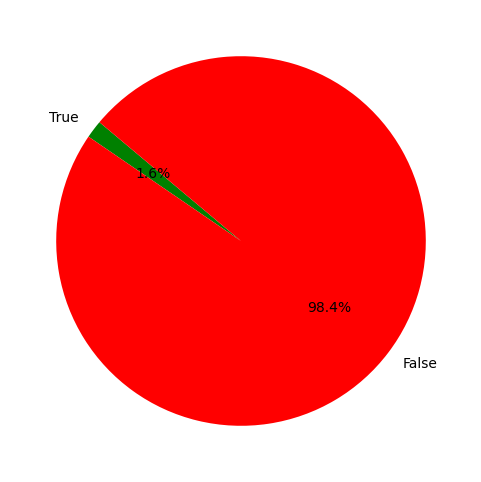

In [14]:
def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code,'2023-10-12','2023-10-13')
        
        if len(df) < 2:
            result[code] = False
        else:
            today_close = df['Close'].iloc[-1]
            yesterday_close = df['Close'].iloc[-2]
            
            if today_close >= yesterday_close * 1.05 :
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(result)
result_TF = list(result_TF.values())

# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count

# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# 그래프 표시
plt.show()